# Technical Interview

This document presents notes and codes about 3 exercices. The code will be in python 2, the data is given in a separate csv (too big for github).

The data were extract from two compressed files. The files were corrupted so I had to use `bzip2recover` to uncompress them.

## Exercise 1

### Task: count the number of lines in Python for each file

We use a csv reader to iterate over the whole file, using a small counter to count the number of (not empty) lines.
Reading the whole file with `f.read()` won't work because of the size of the files.
We found 20 390 199 lines for **searches.csv** and 10 000 011 lines for **bookings.csv**

In [8]:
import csv

with open("./data/searches.csv","r") as f:
    reader = csv.reader(f,delimiter="^")
    i = 0
    for row in reader:
        if row!="\n" and row!="":
            i +=1
    print "nb_searches = %d lines"%i
with open("./data/bookings.csv","r") as f:
    reader = csv.reader(f,delimiter="^")
    i = 0
    for row in reader:
        if row!="\n" and row!="":
            i +=1
    print "nb_bookings = %d lines"%i

nb_searches = 20390199 lines
nb_bookings = 10000011 lines


## Exercise 2

### Task: top 10 arrival airports in the world in 2013 (using the bookings file)

We use a smaller version of bookings.csv for testing. That way,  we can open it with *libre office* to better understand the data and also make faster test. To make this file, we use `head` function and redirect the result to **bookings_head.csv**.  
First, we map all the flight where `duration + off time` is prior to 2014 and after 2012. Then, we reduce all the previous result by adding the pax column and we get the first ten airports. At last, we use **GeoBase** to get the name of the airport.  
We find that we need to chunk the file, aggregate the data by airport, then merge the results.
There was a null value on one column, so we use `dropna` to drop any row that does not have information on `arr_port`, `pax`, `off_time` or `duration`.  
There are still values that cannot be interpreted. It is because we can have a string instead of an int in `duration` (like 'NRT') and also some float that can not be interpreted as float because it has a floating commas intead of the standart point. We handle that by adding NRT to the na_values, and by setting the commas as a decimal separator.  
  
| rank |  arr_port_code |         arr_port_name       |  pax |
|------|:--------------:|:---------------------------:|------|
|0     | LHR            | London Heathrow Airport     | 81439.0|
|1      |LAX          |Los Angeles International Airport | 64230.0|
|2      |LAS           |  McCarran International Airport | 63190.0|
|3      |MCO            |  Orlando International Airport | 62290.0|
|4      |JFK       |John F Kennedy International Airport | 60060.0|
|5      |CDG        |          Paris - Charles-de-Gaulle | 58080.0|
|6      |SFO        |San Francisco International Airport | 53710.0|
|7      |MIA         |       Miami International Airport | 53020.0|
|8      |BKK          |                     Suvarnabhumi | 52660.0|
|9      |DXB           |     Dubai International Airport | 52230.0|

In [79]:
import pandas as pd
import numpy as np
from GeoBases import GeoBase

def process(chunk):
    
    # take the useful columns
    data = chunk[['arr_port','pax','off_time           ','duration']]
    
    # supress NaN rows and change ',' to '.' for float conversion
    data = data.dropna()
    
    # convert off_time column from string to datetime
    off_time = data['off_time           ']
    off_time = pd.to_datetime(off_time)
    off_time = off_time.astype(np.int64)


    # filter the column where duration + off_time < 2014 and off_time+duration >= 2013
    arrival = pd.to_datetime(off_time+data['duration'])
    data = data[arrival < pd.to_datetime("2014-1-1")]
    data = data[arrival >= pd.to_datetime("2013-1-1")]

    # group the number of passenger by airport name
    arrival = data.groupby('arr_port').sum()    
    return arrival
            
arr_data = dict() 
#processing the csv_file in chunks
chunksize = 10 ** 3
i = 0
for chunk in pd.read_csv("./data/bookings.csv", delimiter="^", iterator=True, chunksize=chunksize,
                        na_values = ['NRT     '], decimal=","):
    data = process(chunk)
    for key,value in data['pax'].iteritems():
        if key not in arr_data:
            arr_data[key] = 0
        arr_data[key] += value

# order the result in a list of tuple
arr_data = sorted(arr_data.items(), key=lambda x:x[1], reverse = True)

# use geobase to get the name of the 10 best airports
geo_a = GeoBase(data='airports', verbose=False)
result = []
for i in range(10):  
    name = geo_a.get(arr_data[i][0].strip(),"name")
    result.append((arr_data[i][0],name, arr_data[i][1]))

print pd.DataFrame(result,columns=['arr_port_code','arr_port_name','pax'])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


  arr_port_code                         arr_port_name      pax
0      LHR                    London Heathrow Airport  81439.0
1      LAX          Los Angeles International Airport  64230.0
2      LAS             McCarran International Airport  63190.0
3      MCO              Orlando International Airport  62290.0
4      JFK       John F Kennedy International Airport  60060.0
5      CDG                  Paris - Charles-de-Gaulle  58080.0
6      SFO        San Francisco International Airport  53710.0
7      MIA                Miami International Airport  53020.0
8      BKK                               Suvarnabhumi  52660.0
9      DXB                Dubai International Airport  52230.0


## Exercise 3

### Task: plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona

We then again use a smaller version of searches.csv to make our base functions work. Then we chunk the file to first map the wanted destination and reduce it to reduce memory usage.  
1. Malaga airport is **AGP**  
2. Madrid airport is **MAD **   
3. Barcelona airport is **BCN**  
  
Running a small script, we found that all the data are in 2013, so we are going to plot the data for every month in 2013.  

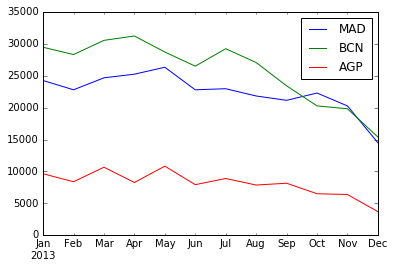

In [3]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# prepare dataframe for plot
rng = pd.date_range("1/2013",periods=12, freq='M')
ts = pd.DataFrame([[0 for i in range(3)] for i in range(12)], index=rng, columns=['MAD', 'BCN', 'AGP'])

def process(chunk):
    # we keep only destination, date
    dt = chunk[['Destination','Date']]
    
    # Filter by arr_code
    is_BCN = dt['Destination'] == "BCN"
    is_MAD = dt['Destination'] == "MAD"
    is_AGP = dt['Destination'] == "AGP"
    dt = dt[is_AGP|is_BCN|is_MAD]
    
    # add the result to the time series
    for row in dt.iterrows():
        destination = row[1]['Destination']
        month = int(row[1]['Date'].split("-")[1])
        ts[destination][month-1] += 1
    
chunksize = 10 ** 3
for chunk in pd.read_csv("./data/searches.csv",delimiter="^", iterator=True, chunksize = chunksize):
    process(chunk)

# plot the result
ts.plot()

## Bonus Exercise
  
### Task: write a Web Service
  
To write it, we will use the code of exercise 2. Because the computation time is very high, we are going to store all the result for all the airpot in a text file using pickle. (We could use a **MongoDB** DataBase to enable fast query instead of reloading the results every times.  

For the web service, we will use **flask**. It doesn't seem like we can test it on jupyter, but it worked on console.

In [14]:
# code from the 2nd exercise, store result using pickle
import pandas as pd
import numpy as np
from GeoBases import GeoBase
import pickle

def process(chunk):
    # take the useful columns
    data = chunk[['arr_port','pax','off_time           ','duration']]
    
    # supress NaN rows and change ',' to '.' for float conversion
    data = data.dropna()
    
    # convert off_time column from string to datetime
    off_time = data['off_time           ']
    off_time = pd.to_datetime(off_time)
    off_time = off_time.astype(np.int64)


    # filter the column where duration + off_time < 2014 and off_time+duration >= 2013
    arrival = pd.to_datetime(off_time+data['duration'])
    data = data[arrival < pd.to_datetime("2014-1-1")]
    data = data[arrival >= pd.to_datetime("2013-1-1")]

    # group the number of passenger by airport name
    arrival = data.groupby('arr_port').sum()    
    return arrival
            
arr_data = dict() 
#processing the csv_file in chunks
chunksize = 10 ** 3
i = 0
for chunk in pd.read_csv("./data/bookings.csv", delimiter="^", iterator=True, chunksize=chunksize,
                        na_values = ['NRT     '], decimal=","):
    data = process(chunk)
    for key,value in data['pax'].iteritems():
        if key not in arr_data:
            arr_data[key] = 0
        arr_data[key] += value

# order the result in a list of tuple
arr_data = sorted(arr_data.items(), key=lambda x:x[1], reverse = True)

# use geobase to get the name of the airports
geo_a = GeoBase(data='airports', verbose=False)
# we compute the results adding the airpport name for all the airport and store it in a list
result = []
for arr in arr_data:   
    try:
        name = geo_a.get(arr[0].strip(),"name")
    except KeyError:
        name = "Not Found"
    result.append((arr[0],name, arr[1]))

with open("./data/results.txt","w") as f:
    pickle.dump(result, f)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [16]:
# web service that use results.txt to send JSON
# query /airport/{i} where i is an integer to get the i best airports
import pickle
from flask import Flask, jsonify, abort

app = Flask(__name__)

@app.route('/airports/<int:n_best>', methods=['GET'])
def getNBest(n_best):
    with open("./data/results.txt","r") as f:
        result = pickle.load(f)
        airports = []
        if n_best>0:
            if n_best < len(result):
                for i in range(n_best):
                    airports.append({
                        'rank' : i+1,
                        'arr_code' : result[i][0],
                        'arr_name' : result[i][1],
                        'pax' : result[i][2]
                    })
            else:
                for i in range(len(result)):
                    airport.append({
                        'rank' : i+1,
                        'arr_code' : result[i][0],
                        'arr_name' : result[i][1],
                        'pax' : result[i][2]
                    })
        else:
            # Bad Request (if n =0)
            abort(400)
        return jsonify({'airports': airports})

if __name__ == '__main__':
    app.run(debug=True, port= 15000)


SystemExit: 1

To exit: use 'exit', 'quit', or Ctrl-D.


## Bonus Exercise

### Task: match searches with bookings

